In [1]:
import matplotlib.pylab as plt
import numpy as np

# Ray tracing Vectorized

Notation for the points:  
* $A$: beam origin
* $B$: beam intersection with sample plane
* $C$: diffracted beam intersection with detector plane
* $D$: incident beam intersection with detector plane (direct beam)


In [2]:
def normalize(array_of_vector):
    '''Return an array of normed vector.
    
       (vector along the last dim)
       i.e. a (nbre_vector, n_dim) array'''
    array_of_vector = np.asarray(array_of_vector)
    norm = np.linalg.norm(array_of_vector, axis=-1, keepdims=True)
    return  np.divide(array_of_vector, norm, where=norm>0)

# test
assert np.allclose(normalize(np.array((2, 0, 0))),
                   np.array((1, 0, 0)))
assert np.allclose(normalize(np.array([(0, 2, 0), (0, -3, 0), (0, 0, 0), (-1, 0, 0)])),
                   np.array([(0, 1, 0), (0, -1, 0), (0, 0, 0), (-1, 0, 0)]))

In [3]:
def plane_intersection(A, u, plane_center, plane_normal):
    '''Intersection point of incident rays with a plane.
    
    returns naN if no intersection (i.e. when opposite direction or parallel)
    
    Parameters
    ----------
    A : (N, dim) ndarray
        starting points of the incident rays
    u : (N, dim) ndarray
        directions of the incident rays
    plane_center : (dim, ) vector
        position of the intersection plane
    plane_normal : (dim, ) vector
        normal of the intersection plane
        
    Returns
    -------
    B : (N, dim) ndarray
        points of intersection for each rays
    
    '''
    # Intersection of incident beams with sample plane:
    A = np.asarray(A, dtype=np.float64)
    u = np.asarray(u, dtype=np.float64)

    AP_dot_n = np.inner((A - plane_center), plane_normal)
    u_dot_n = np.inner(u, plane_normal)

    t = - np.divide(AP_dot_n, u_dot_n,
                    where=np.logical_not(np.isclose(u_dot_n, 0)))
    t[t<0] = np.NaN
    B = A + u*t[:, np.newaxis]
    return B

# test
A = np.array([(1, 0, 0), (2, 1, 0), (1, 0, 1), (1, 0, 0),
              (-1, 0, 0), (-1, 0, 0), (2, 0, 1), (2, 2, -2)])
u = np.array([(-1, 0, 0), (-1, 0, 0), (-1, 0, 0), (-1, 0, -1),
              (-1, 0, 0), (1, 0, 1), (1, 0, 0), (1, 0, 0)])

plane_center = np.array((0, 0, 0))
plane_normal = np.array((1, 0, 1))

assert np.allclose(plane_intersection(A, u, plane_center, plane_normal),
                   np.array([[ 0. ,  0. ,  0. ],
                           [ 0. ,  1. ,  0. ],
                           [-1. ,  0. ,  1. ],
                           [ 0.5,  0. , -0.5],
                           [ np.nan,  np.nan,  np.nan],
                           [-0.5,  0. ,  0.5],
                           [ np.nan,  np.nan,  np.nan],
                           [ 2. ,  2. , -2. ]]), equal_nan=True)

In [72]:
def projection_detector_plane(A, u, detector_position, detector_normal, detector_vertical):
    """Projection on a plane, returns coordinates in local in-plane base """
    detector_vertical = normalize(detector_vertical)
    detector_normal = normalize(detector_normal)

    detector_horizontal = np.cross(detector_normal, detector_vertical)

    P = plane_intersection(A, u, detector_position, detector_normal)

    P_prime = P - detector_position
    detector_v = np.dot(P_prime, detector_vertical)
    detector_u = np.dot(P_prime, detector_horizontal)
    
    return detector_u, detector_v

In [81]:
def diffracted_cone(u,
                    alpha,
                    gamma_span,
                    gamma_zero_direction = np.array((0, 0, 1)),
                    reshape=True):
    ''' Returns diffracted directions by a powder (cone)
        
        vertical_axis define the gamma=pi/2 '?'
        
        Parameters
        ----------
        u : 
        
        alpha : float, radian
            demi angle of the cone
        gamma_span : array, radian
            angle at which new rays are diffracted
        gamma_zero_direction : vector
            direction along which gamma=0
            toward gamma>0
        reshape : boolean
            if True return a (N * len(gamma_span), dim) array
            else a (N, len(gamma_span), dim) array
            
        Returns
        -------
        d : array (N * len(gamma_span), dim)
            diffracted direction 
    '''
    gamma_span = np.asarray(gamma_span)

    # Define a new base
    u = normalize( u )
    w = normalize( np.cross(u, gamma_zero_direction) )
    v = np.cross(w, u)
    
    cos_gamma = np.cos(gamma_span)
    sin_gamma = np.sin(gamma_span) 
    rho = np.tan(alpha)
    
    # diffracted directions:
    d = u[:, :, np.newaxis] + \
        v[:, :, np.newaxis]*rho * cos_gamma + \
        w[:, :, np.newaxis]*rho * sin_gamma
    
    d = d.swapaxes(1, 2)  # coordonitates along the last dimension
    
    if reshape:
        d = d.reshape(-1, 3, order='C')
    #  ‘C’ means to read / write the elements ... with the last axis index changing fastest, 
    
    return d

# test
u = np.array(((1, 0, 0), (-10, 0, 0)))

d = diffracted_cone(u, np.pi/4, (0, np.pi/2, -np.pi/2, np.pi/3), reshape=True)
d.shape

(8, 3)

In [185]:
def source(N, beam_shape, beam_divergence):
    Ax = np.ones((N, 1)) * rayon_gonio
    Ay = (np.random.randn(N, 1)) * beam_shape[1]  # Gaussian
    Az = (np.random.rand(N, 1)-0.5) * beam_shape[0] # mm, Square

    u_incident_x = -np.ones((N, 1))
    u_incident_y = np.random.randn(N, 1) * beam_divergence[1]  # divergence
    u_incident_z = np.random.randn(N, 1) * beam_divergence[0]

    A = np.hstack([Ax, Ay, Az])
    u = normalize( np.hstack([u_incident_x, u_incident_y, u_incident_z]) )
    
    return A, u

In [186]:
# Powder diff
def powder_diffraction(A, u, deuxtheta, omega,
                       nbr_gamma_rays, gamma_range):
    
    sample_position  = normalize((0, 0, 0))
    sample_normal = normalize((+np.sin(omega), 0, +np.cos(omega)))

    # Intersection of incident beam with sample plane:
    B = plane_intersection(A, u, sample_position, sample_normal)
    
    
    gamma_offset = 0
    gamma_span = np.linspace(gamma_offset - gamma_range,
                             gamma_offset + gamma_range,
                             nbr_gamma_rays)  # bug... no Gamma=0... 

    d = diffracted_cone(u, deuxtheta,
                        gamma_span, reshape=True)

    # Broadcast B to the shape of d
    B_prime = np.repeat(B[:, :, np.newaxis], nbr_gamma_rays, 2)

    B_prime = B_prime.swapaxes(1, 2)  # coordonitates along the last dimension
    B_prime = B_prime.reshape(-1, 3, order='C')
    
    return B_prime, d

In [187]:
# inputs
rayon_gonio = 320 # mm
# Incident beam
N = 200
beam_shape = (0.5, 10)  # mm, (width, height)
beam_divergence = (0, 0)

A, u = source(N, beam_shape, beam_divergence)

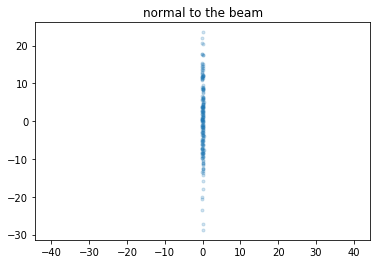

In [188]:
# pseudo detector plane
detector_normal = np.array((1, 0, 0))
detector_vertical = np.array((0, 1, 0))
detector_position = np.array((0, 0, 0))

detector_u, detector_v = projection_detector_plane(A, u,
                                                   detector_position,
                                                   detector_normal,
                                                   detector_vertical)

# Graph
plt.plot(detector_u, detector_v, '.', alpha=0.2);
plt.axis('equal'); plt.title('normal to the beam');

In [190]:
# Diff by the powder
deuxtheta = np.pi/3
omega = deuxtheta/2
nbr_gamma_rays = 15
gamma_range = 5 *np.pi/180 # rad

B, d = powder_diffraction(A, u, deuxtheta, omega,
                       nbr_gamma_rays, gamma_range)

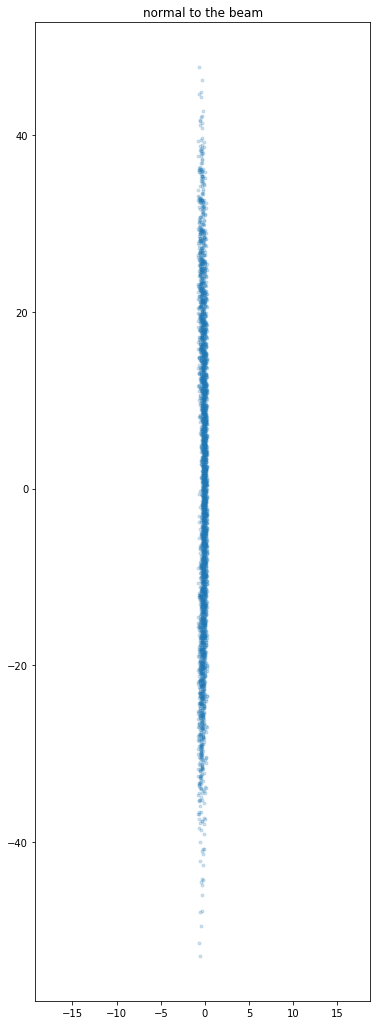

In [191]:
# detector plane

detector_position  = np.array((-rayon_gonio*np.cos(deuxtheta),
                              0,
                              +rayon_gonio*np.sin(deuxtheta)))
detector_normal = normalize(np.array((+np.cos(deuxtheta),
                                  0,
                                  -np.sin(deuxtheta))))

detector_vertical = normalize(np.array((0, 1, 0)))

detector_u, detector_v = projection_detector_plane(B, d,
                                                   detector_position,
                                                   detector_normal,
                                                   detector_vertical)


# Graph
plt.figure(figsize=(6,18))
plt.plot(detector_u, detector_v, '.', alpha=0.2);
plt.axis('equal'); plt.title('normal to the beam');

## Old

In [45]:
def trace(deuxtheta, theta_bragg):
    '''Powder diffraction ray tracing
    
    
    '''
    # Define detector
    detector_position  = np.array((-rayon_gonio*np.cos(deuxtheta),
                                  0,
                                  +rayon_gonio*np.sin(deuxtheta)))
    detector_normal = normed(np.array((+np.cos(deuxtheta),
                                      0,
                                      -np.sin(deuxtheta))))
    detector_vertical = normed(np.array((0, 1, 0)))
    detector_horizontal = np.cross(detector_normal, detector_vertical)

    # Define sample
    omega = deuxtheta/2
    sample_position  = normed((0, 0, 0))
    sample_normal = normed((+np.sin(omega), 0, +np.cos(omega)))

    # Intersection of incident beam with sample plane:
    B = plane_intersection(A, u_incident, sample_position, sample_normal)

    
    # Diffracted cone:

    # detector base vector - relative to the cone axis
    v_plane = np.cross(detector_normal, u_incident) # vertical
    norm_v = np.linalg.norm(v_plane, axis=-1, keepdims=False)
    v_plane[np.isclose(norm_v, 0)] = detector_vertical
    v_plane = normed(v_plane)

    u_plane = np.cross(detector_normal, v_plane)

    # faisceau direct dans le plan du detecteur
    D = plane_intersection(A, u_incident,
                           detector_position,
                           detector_normal)

    # Inclinaison angle
    cos_beta = np.abs(np.dot(u_incident, detector_normal))[:, np.newaxis]
    sin_beta = np.linalg.norm( np.cross(u_incident, detector_normal),
                              axis=-1 )[:, np.newaxis]

    nbr_gamma_rays = 55  # nrb of diffracted rays for each incident ray
    gamma_range = 5 *np.pi/180 # rad
    gamma_offset = 0
    gamma = np.linspace(-gamma_range+gamma_offset,
                        +gamma_range+gamma_offset, nbr_gamma_rays)  # no Gamma=0... 
    cos_Gamma = np.cos(gamma)
    sin_Gamma = np.sin(gamma)
    tan_alpha = np.tan( 2*theta_bragg )#20*np.pi/180 )  # tan theta

    
    # Distance du plan par rapport au sommet du cone, sur  l'axe du cone
    z0 = np.linalg.norm(D - B, axis=-1, keepdims=True)

    racine = np.sqrt(cos_beta**2 * cos_Gamma**2 + sin_Gamma**2)
    up = tan_alpha*sin_beta*cos_Gamma - racine
    below = -tan_alpha**2 * sin_beta**2 * cos_Gamma**2 + sin_Gamma**2 + cos_Gamma**2*cos_beta**2
    rho = -np.divide(tan_alpha * z0 * up, below, where=np.abs(below)>0)  # not true for gamma=0

    # Diffracted point on the detecteur plane,
    # using absolute coordiantes
    C_from_axis = (rho*cos_Gamma)[:, :, np.newaxis] * u_plane[:, np.newaxis, :] \
                 +(rho*sin_Gamma)[:, :, np.newaxis] * v_plane[:, np.newaxis, :]

    C = C_from_axis + D[:, np.newaxis, :]
    #C = C.reshape((-1, 3))

    # Get diffracted ray angle in the XZ plane (true deux-theta)
    u_diff = normed( (C - B[:, np.newaxis, :]).reshape((-1, 3)) ) # Direction of the diffracted beams
    u_diff_XZ = np.multiply(u_diff, np.array((1, 0, 1))) # projection on the XZ plane
    delta_deuxtheta_diffracted = np.arctan2(u_diff[:, 2], -u_diff[:, 0]) - deuxtheta

    # Projection back in the detecteur plane
    uy_direct_beam = np.dot(D, detector_vertical)
    uz_direct_beam = np.dot(D, detector_horizontal)

    uz = np.dot(C , detector_horizontal)
    uy = np.dot(C , detector_vertical)

    # Detector transmitance (clip)
    detector_height = 30 # mm
    acceptance_deg = 1/4 # degree
    detector_width = acceptance_deg *np.pi/180 * rayon_gonio

    vertical_clip = np.logical_and(uy < detector_height/2, uy > -detector_height/2)
    horizontal_clip = np.logical_and(uz < detector_width/2, uz > -detector_width/2)
    # Acceptance clip (on delta_deuxtheta)

    total_clip = np.logical_and(vertical_clip, horizontal_clip)

    N = total_clip.sum()

    return N

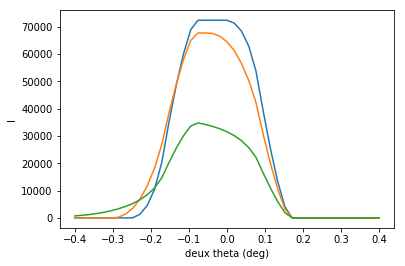

In [58]:
theta_bragg = 10 *np.pi/180

angle_range = 0.8 # deg
deuxtheta_span = 2*theta_bragg + np.linspace(-angle_range/2, +angle_range/2, 43)*np.pi/180

I = [trace(deuxtheta, theta_bragg) for deuxtheta in deuxtheta_span]

plt.plot((deuxtheta_span-2*theta_bragg) *180/np.pi, I);
plt.xlabel('deux theta (deg)'); plt.ylabel('I');


theta_bragg = 15 *np.pi/180

angle_range = 0.8 # deg
deuxtheta_span = 2*theta_bragg + np.linspace(-angle_range/2, +angle_range/2, 43)*np.pi/180

I = [trace(deuxtheta, theta_bragg) for deuxtheta in deuxtheta_span]

plt.plot((deuxtheta_span-2*theta_bragg) *180/np.pi, I);
plt.xlabel('deux theta (deg)'); plt.ylabel('I');



theta_bragg = 30 *np.pi/180

angle_range = 0.8 # deg
deuxtheta_span = 2*theta_bragg + np.linspace(-angle_range/2, +angle_range/2, 43)*np.pi/180

I = [trace(deuxtheta, theta_bragg) for deuxtheta in deuxtheta_span]

plt.plot((deuxtheta_span-2*theta_bragg) *180/np.pi, I);
plt.xlabel('deux theta (deg)'); plt.ylabel('I');

In [ ]:


#plt.plot(A[:, 2], A[:, 1], 's')
#plt.plot(D[:, 2], D[:, 1], 'x')
plt.figure(figsize=(5, 10))
plt.plot(uz/rayon_gonio *180/np.pi, uy, ',');
#plt.plot(uz_direct_beam, uy_direct_beam, 'x', alpha=0.5);
#plt.axis('equal');
plt.title('detector plane -deuxTheta=%.2f°' % (180/np.pi*deuxtheta))
plt.xlabel('z _dect (deg)'); plt.ylabel('y (mm)');

In [ ]:
plt.figure(figsize=(5, 10))
plt.plot(uz[total_clip]/rayon_gonio *180/np.pi, uy[total_clip], ',');
#plt.plot(uz_direct_beam, uy_direct_beam, 'x', alpha=0.5);
#plt.axis('equal');
plt.title('detector plane -deuxTheta=%.2f°' % (180/np.pi*deuxtheta))
plt.xlabel('z _dect (deg)'); plt.ylabel('y (mm)');

### Improvements:
* equation for cone intersection with cylinder, instead of plane
